In [58]:
from google.cloud import storage
from io import BytesIO
import zipfile
import sqlite3
import gc
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as ctx
from datetime import datetime
import time

# ETL

### Getting the data

I will use the google cloud python library for reading the data stored on google storage.

In [2]:
client = storage.Client.create_anonymous_client()
bucket = client.bucket('hiring-test')
blobs = list(bucket.list_blobs())

In [10]:
blobs

[<Blob: hiring-test, data.zip, 1583923294091926>,
 <Blob: hiring-test, data_dictionary_trip_records_yellow.pdf, 1601449662636185>,
 <Blob: hiring-test, nyc_acs_demographics.csv, 1601390672584333>,
 <Blob: hiring-test, nyc_cbg_geoms.geojson, 1601448241250046>]

#### NYC taxi data

I will extract each file in data.zip and then conactenate all.

In [ ]:
blob = storage.blob.Blob("data.zip",bucket)
content = blob.download_as_string()

In [5]:
z = zipfile.ZipFile(BytesIO(content), 'r')

files = z.namelist()
csvs = []

for name in files[1:]:
    data = z.open(name)
    csvs.append(pd.read_csv(data, header= None, low_memory=False))
    print(f'{name} processed')

nyc_taxis = pd.concat(csvs, axis=0)

data/yellow_tripdata_2015-07_00 processed
data/yellow_tripdata_2015-01_00 processed
data/yellow_tripdata_2015-01_01 processed
data/yellow_tripdata_2015-01_02 processed
data/yellow_tripdata_2015-01_03 processed
data/yellow_tripdata_2015-01_04 processed
data/yellow_tripdata_2015-01_05 processed
data/yellow_tripdata_2015-01_06 processed
data/yellow_tripdata_2015-01_07 processed
data/yellow_tripdata_2015-01_08 processed
data/yellow_tripdata_2015-01_09 processed
data/yellow_tripdata_2015-01_10 processed
data/yellow_tripdata_2015-01_11 processed
data/yellow_tripdata_2015-01_12 processed
data/yellow_tripdata_2015-01_13 processed
data/yellow_tripdata_2015-01_14 processed
data/yellow_tripdata_2015-01_15 processed
data/yellow_tripdata_2015-01_16 processed
data/yellow_tripdata_2015-01_17 processed
data/yellow_tripdata_2015-01_18 processed
data/yellow_tripdata_2015-01_19 processed
data/yellow_tripdata_2015-01_20 processed
data/yellow_tripdata_2015-01_21 processed
data/yellow_tripdata_2015-01_22 pr

In [6]:
nyc_taxis.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
1,1,2015-07-01 00:00:00,2015-07-01 00:15:26,1,3.50,-73.994155883789063,40.751125335693359,1,N,-73.976821899414063,40.788566589355469,2,14,0.5,0.5,0,0,0.3,15.3
2,1,2015-07-01 00:00:00,2015-07-01 00:22:22,1,3.90,-73.984657287597656,40.768486022949219,1,N,-74.000129699707031,40.734897613525391,2,17,0.5,0.5,0,0,0.3,18.3


In [7]:
nyc_taxis.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37383561 entries, 0 to 62783
Data columns (total 19 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   0       object
 1   1       object
 2   2       object
 3   3       object
 4   4       object
 5   5       object
 6   6       object
 7   7       object
 8   8       object
 9   9       object
 10  10      object
 11  11      object
 12  12      object
 13  13      object
 14  14      object
 15  15      object
 16  16      object
 17  17      object
 18  18      object
dtypes: object(19)
memory usage: 26.8 GB


Because of the large RAM memory requirements (and time) to manipulate this dataset, I will create a databse in SQLite to query an manipulate only the information needed in each moment, using much less memory.

_*I tried Google Colab but I faced the same problem._

First I will fix the header:

In [29]:
header = nyc_taxis.iloc[0]
nyc_taxis.columns = header 
nyc_taxis = nyc_taxis.iloc[1:] 

In [50]:
nyc_taxis.reset_index(drop=True, inplace=True)

In [60]:
nyc_taxis.head(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2015-07-01 00:00:00,2015-07-01 00:15:26,1,3.50,-73.994155883789063,40.751125335693359,1,N,-73.976821899414063,40.788566589355469,2,14,0.5,0.5,0,0,0.3,15.3
1,1,2015-07-01 00:00:00,2015-07-01 00:22:22,1,3.90,-73.984657287597656,40.768486022949219,1,N,-74.000129699707031,40.734897613525391,2,17,0.5,0.5,0,0,0.3,18.3
2,1,2015-07-01 00:00:00,2015-07-01 00:07:42,1,2.30,-73.978889465332031,40.762287139892578,1,N,-74.004219055175781,40.752532958984375,2,9,0.5,0.5,0,0,0.3,10.3


Then I will followed this steps after some testing:
- Save the .csv file in three chunks to drop the two rows which contain the columns names (because previous concatenation of the files). I have atempting Boolean masking, etc. but again RAM memory run out.
- Join the three .csv files into one.
- Import .csv file into a SQLite table (externally created with DB Browser).
- Export and load when needed the final database.

In [53]:
nyc_taxis[nyc_taxis.VendorID == 'VendorID']

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
499999,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
13248986,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount


In [62]:
nyc_taxis1 = nyc_taxis.iloc[1:499999] 
nyc_taxis2 = nyc_taxis.iloc[500000:13248986] 
nyc_taxis3 = nyc_taxis.iloc[13248987:] 

In [66]:
nyc_taxis1.to_csv('data/nyc_taxis1.csv', index=False)
nyc_taxis2.to_csv('data/nyc_taxis2.csv', index=False)
nyc_taxis3.to_csv('data/nyc_taxis3.csv', index=False)

In [6]:
db = sqlite3.connect("data/nyc_taxis.db")

In [7]:
pd.read_sql("SELECT * FROM nyc_taxis LIMIT 3", db)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance\t,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag\t,dropoff_longitude\t,dropoff_latitude,payment_type,fare_amount\t,extra,mta_tax\t,tip_amount,tolls_amount\t,improvement_surcharge,total_amount
0,1,2015-07-01 00:00:00,2015-07-01 00:22:22,1,3.9,-73.984657,40.768486,1,N,-74.000130,40.734898,2,17.0,0.5,0.5,0.00,0.0,0.3,18.30
1,1,2015-07-01 00:00:00,2015-07-01 00:07:42,1,2.3,-73.978889,40.762287,1,N,-74.004219,40.752533,2,9.0,0.5,0.5,0.00,0.0,0.3,10.30
2,1,2015-07-01 00:00:00,2015-07-01 00:39:37,1,9.2,-73.992790,40.742760,1,N,-73.971512,40.637154,1,33.0,0.5,0.5,8.55,0.0,0.3,42.85


In [8]:
db.close()

#### ACS demographic and socio-economic data by census block group

In [3]:
blob = storage.blob.Blob("nyc_acs_demographics.csv",bucket)
content = blob.download_as_string()

nyc_acs = pd.read_csv(BytesIO(content))

In [18]:
nyc_acs.head()

,Unnamed: 0,geoid,acs_demog_var,value
0,0,360050001001,total_pop,7080.0
1,1,360050001001,two_or_more_races_pop,41.0
2,2,360050001001,vacant_housing_units_for_rent,0.0
3,3,360050001001,unemployed_pop,0.0
4,4,360050001001,black_pop,3984.0


In [4]:
nyc_acs.drop('Unnamed: 0', axis=1, inplace=True)

In [20]:
nyc_acs.dtypes

geoid              int64
acs_demog_var     object
value            float64
dtype: object

#### NYC census block group geometries

In [5]:
blob = storage.blob.Blob("nyc_cbg_geoms.geojson",bucket)
content = blob.download_as_string()

nyc_geo = gpd.read_file(BytesIO(content))

In [22]:
nyc_geo.head()

,geoid,geometry
0,360050001001,"POLYGON ((-73.89277 40.79284, -73.89261 40.792..."
1,360050002001,"POLYGON ((-73.86285 40.81267, -73.86191 40.812..."
2,360050002002,"POLYGON ((-73.86708 40.81444, -73.86332 40.812..."
3,360050002003,"POLYGON ((-73.85856 40.80665, -73.85848 40.806..."
4,360050004001,"POLYGON ((-73.85972 40.81527, -73.85956 40.815..."


In [23]:
nyc_geo.dtypes

geoid         object
geometry    geometry
dtype: object

In [6]:
nyc_geo['geoid'] = nyc_geo['geoid'].astype('int64')

In [25]:
nyc_geo.dtypes

geoid          int64
geometry    geometry
dtype: object

Now the data types are correct.

## Data exploration and cleaning

Because RAM memory issues occurred as comented before, I will delete a dataframe and a list when its not going to be used anymore, hoping to release some memory.

_*delete dataframe function only works manually after some testing_

In [8]:
def del_list(_list):
    del _list[:]
    del _list 

### NYC taxi data

In [7]:
db = sqlite3.connect("data/nyc_taxis.db")

In [5]:
pd.read_sql("SELECT * FROM nyc_taxis LIMIT 3", db)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2015-07-01 00:00:00,2015-07-01 00:22:22,1,3.9,-73.984657,40.768486,1,N,-74.000130,40.734898,2,17.0,0.5,0.5,0.00,0.0,0.3,18.30
1,1,2015-07-01 00:00:00,2015-07-01 00:07:42,1,2.3,-73.978889,40.762287,1,N,-74.004219,40.752533,2,9.0,0.5,0.5,0.00,0.0,0.3,10.30
2,1,2015-07-01 00:00:00,2015-07-01 00:39:37,1,9.2,-73.992790,40.742760,1,N,-73.971512,40.637154,1,33.0,0.5,0.5,8.55,0.0,0.3,42.85


#### Missing data

I will query each feature and check its missing data:

In [6]:
cur = db.cursor()
cur.execute("PRAGMA table_info(nyc_taxis)")
row = cur.fetchall()

columns = []

for n in range(0,len(row)):
    columns.append(row[n][1])

In [7]:
columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'pickup_longitude',
 'pickup_latitude',
 'RatecodeID',
 'store_and_fwd_flag',
 'dropoff_longitude',
 'dropoff_latitude',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount']

In [8]:
for column in columns:
    df = pd.read_sql(f"SELECT {column} FROM nyc_taxis", db)
    print(df.isnull().sum())

VendorID    0
dtype: int64
tpep_pickup_datetime    1
dtype: int64
tpep_dropoff_datetime    1
dtype: int64
passenger_count    1
dtype: int64
trip_distance    1
dtype: int64
pickup_longitude    1
dtype: int64
pickup_latitude    1
dtype: int64
RatecodeID    1
dtype: int64
store_and_fwd_flag    1
dtype: int64
dropoff_longitude    1
dtype: int64
dropoff_latitude    1
dtype: int64
payment_type    1
dtype: int64
fare_amount    1
dtype: int64
extra    1
dtype: int64
mta_tax    1
dtype: int64
tip_amount    1
dtype: int64
tolls_amount    1
dtype: int64
improvement_surcharge    4
dtype: int64
total_amount    1
dtype: int64


There is very little missing data.

#### Data exploration

- **Pickup and dropoff**

In [10]:
query = pd.read_sql("SELECT pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude FROM nyc_taxis", db)

In [7]:
query.dtypes

pickup_latitude      object
pickup_longitude     object
dropoff_latitude     object
dropoff_longitude    object
dtype: object

There is probably floats and integers/strings mixed (error after trying changing data type), so I will create a new clean dataframe:

In [11]:
plat = []
plon = []
dlat = []
dlon = []

for pla,plo,dla,dlo in zip(query['pickup_latitude'], query['pickup_longitude'],query['dropoff_latitude'],query['dropoff_longitude']):
    if isinstance(pla, float) == True and isinstance(plo, float) == True and isinstance(dla, float) == True and isinstance(dlo, float) == True:
        plat.append(pla)   
        plon.append(plo)   
        dlat.append(dla)
        dlon.append(dlo)

In [12]:
query = pd.DataFrame(list(zip(plat,plon,dlat,dlon)),columns=['pickup_lat', 'pickup_lon','dropoff_lat', 'dropoff_lon'])

In [13]:
del_list(plat)
del_list(plon)
del_list(dlat)
del_list(dlon)

Text(0, 0.5, 'Latitude')

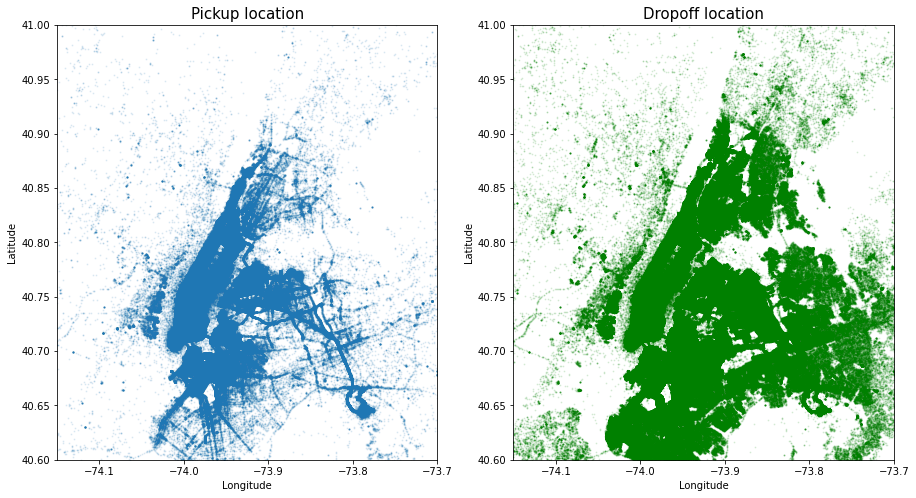

In [14]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(121)
ax1.scatter(query.pickup_lon,query.pickup_lat,s=1,alpha=0.1)
plt.ylim([40.60,41.00])
plt.xlim([-74.15,-73.70])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Pickup location',fontsize=15)

ax2 = fig.add_subplot(122)
ax2.scatter(query.dropoff_lon,query.dropoff_lat,s=1,color='green',alpha=0.1)  
plt.ylim([40.60,41.00])
plt.xlim([-74.15,-73.70])
plt.title('Dropoff location',fontsize=15)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

It is notable the condensation of the pickups and the more expanded dropoffs.

In [15]:
del query
gc.collect()
query = pd.DataFrame()

- **Pickup and dropoff hours and months**

In [16]:
_datetime = pd.read_sql("SELECT tpep_pickup_datetime AS pickup, tpep_dropoff_datetime AS dropoff FROM nyc_taxis", db)

In [19]:
_datetime.head(3)

,pickup,dropoff
0,2015-07-01 00:00:00,2015-07-01 00:22:22
1,2015-07-01 00:00:00,2015-07-01 00:07:42
2,2015-07-01 00:00:00,2015-07-01 00:39:37


In [44]:
_datetime.isnull().sum()

pickup     1
dropoff    1
dtype: int64

In [17]:
_datetime.dropna(inplace=True)

In [18]:
pickup_hour = []
dropoff_hour = []
pickup_months = []
dropoff_months = []


for pickup, dropoff in zip(_datetime['pickup'], _datetime['dropoff']):
    if '_d' not in pickup: #some datetime value have or is '_d'. I encountered it by testing
        pickup_hour.append(int(pickup[11:13]))
        dropoff_hour.append(int(dropoff[11:13]))
        pickup_months.append(int(pickup[5:7]))
        dropoff_months.append(int(dropoff[5:7]))
    else:
        pickup_hour.append(pickup_hour[-1])
        dropoff_hour.append(dropoff_hour[-1])   
        pickup_months.append(pickup_months[-1])
        dropoff_months.append(dropoff_months[-1])

In [19]:
_datetime['pickup_hour'] = pickup_hour
_datetime['dropoff_hour'] = dropoff_hour
_datetime['pickup_months'] = pickup_months
_datetime['dropoff_months'] = dropoff_months

In [21]:
del_list(pickup_hour)
del_list(dropoff_hour)
del_list(pickup_months)
del_list(dropoff_months)

In [33]:
_datetime.head(3)

,pickup,dropoff,pickup_hour,dropoff_hour,pickup_months,dropoff_months
0,2015-07-01 00:00:00,2015-07-01 00:22:22,0,0,7,7
1,2015-07-01 00:00:00,2015-07-01 00:07:42,0,0,7,7
2,2015-07-01 00:00:00,2015-07-01 00:39:37,0,0,7,7


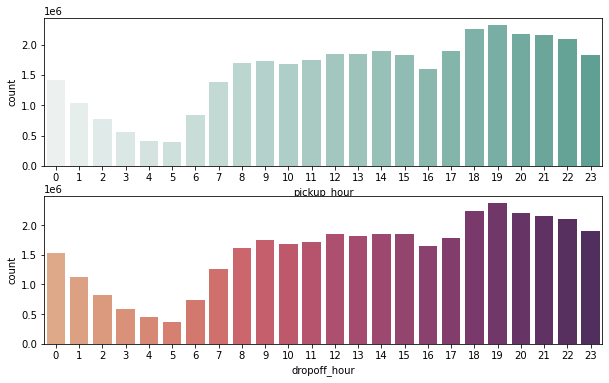

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[10,6])

c1 = sns.countplot(data=_datetime, x = 'pickup_hour', palette = "light:#5A9", ax=ax1)
c2 = sns.countplot(data=_datetime, x = 'dropoff_hour', palette = "flare", ax=ax2)

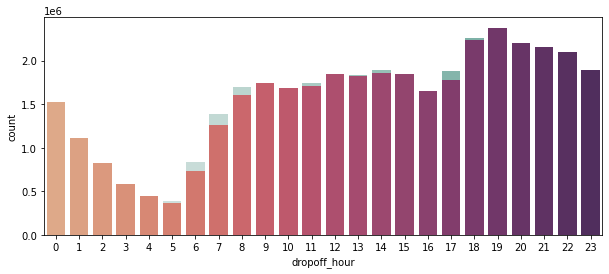

In [17]:
plt.figure(figsize=[10,4])
sns.countplot(data=_datetime, x = 'pickup_hour', palette = "light:#5A9", alpha=0.5)
sns.countplot(data=_datetime, x = 'dropoff_hour', palette = "flare", alpha=0.5)

The pickup and the dropoff hours seem to be really close.
- Pickup hours are around 6-8 PM.
- Off-pickup hours are around 5 PM.

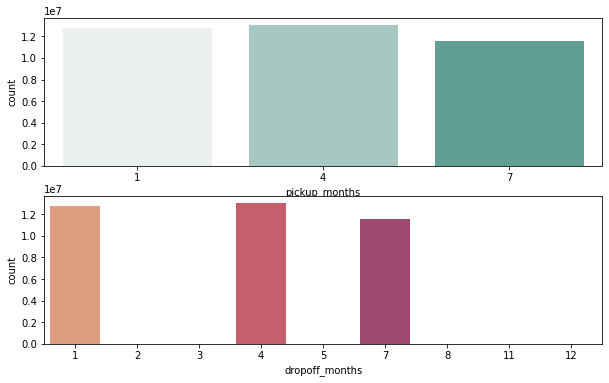

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[10,6])

c1 = sns.countplot(data=_datetime, x = 'pickup_months', palette = "light:#5A9", ax=ax1)
c2 = sns.countplot(data=_datetime, x = 'dropoff_months', palette = "flare", ax=ax2)

- The data shows the months which the data where retrieved from (January, April, July).
- In July the there are less trips due to vacation time I guess.

In [22]:
del _datetime
gc.collect()
_datetime = pd.DataFrame()

In [23]:
del query
gc.collect()
query = pd.DataFrame()

- **RateCode and Payment_type**

In [22]:
query = pd.read_sql_query('SELECT RatecodeID, payment_type FROM nyc_taxis', db)

In [23]:
query['payment_type'].fillna(0, inplace = True)

In [25]:
query['payment_type'].value_counts()

1               23200637
2               14021417
3                 121439
4                  40058
5                      6
payment_type           2
0                      1
Name: payment_type, dtype: int64

In [26]:
query['payment_type'].replace('payment_type', 6, inplace=True)

In [27]:
query['payment_type'] = query['payment_type'].astype(int)

Text(0.5, 1.0, 'Payment Type Count')

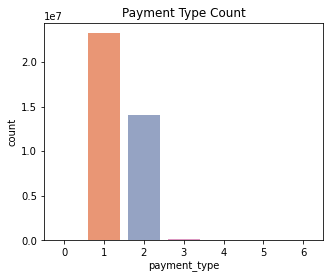

In [34]:
plt.figure(figsize=[5,4])
sns.countplot(data=query, x = 'payment_type', palette = "Set2")

plt.title('Payment Type Count')

The prefered payment type is 1 (Credit cash) before than 2 (cash) which may surprise some people.

In [36]:
query['RatecodeID'].value_counts()

1             36459765
2               737546
5               111617
3                58493
4                13623
99                2099
6                  414
RatecodeID           2
Name: RatecodeID, dtype: int64

In [39]:
query['RatecodeID'].replace('payment_type', 0, inplace=True)
query['RatecodeID'] = query[query['RatecodeID'] != 99]

Text(0.5, 1.0, 'RatecodeID Count')

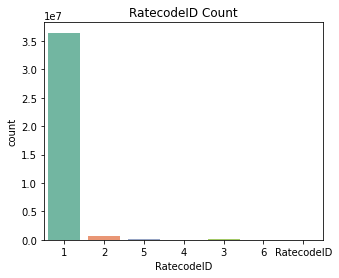

In [40]:
plt.figure(figsize=[5,4])
sns.countplot(data=query, x = 'RatecodeID', palette = "Set2")

plt.title('RatecodeID Count')

The principal rate is the standard one (1). There JFK airport rate is low in comparison (2) and the negociated rates are rare (5). I don't know why there is two 'RatecodeID values', I suppose there are errors.

In [41]:
del query
gc.collect()
query = pd.DataFrame()

- **Fare amount distribution**

In [5]:
query = pd.read_sql_query('SELECT fare_amount FROM nyc_taxis', db)

In [48]:
query.dtypes

fare_amount     object
tip_amount      object
total_amount    object
dtype: object

In [45]:
query['fare_amount'].value_counts()

6.00      1847831
6.50      1842533
7.00      1807290
5.50      1784455
7.50      1740411
           ...   
35.24           1
36.99           1
38.74           1
37.37           1
438.97          1
Name: fare_amount, Length: 3625, dtype: int64

Float and integer values are mixed. I will create a clean dataframe:

In [7]:
fare_l = []

for fare,tip in query['fare_amount']:
    if isinstance(fare, float) == True:
        fare_l.append(float(fare))

In [8]:
query = pd.DataFrame(fare_l,columns=['fare_amount'])

In [56]:
query['fare_amount'].value_counts()

6.00     1847831
6.50     1842533
7.00     1807290
5.50     1784455
7.50     1740411
          ...   
4.88           1
7.38           1
7.88           1
6.12           1
18.90          1
Name: fare_amount, Length: 3624, dtype: int64

In [60]:
query['fare_amount'].max()

210523.47

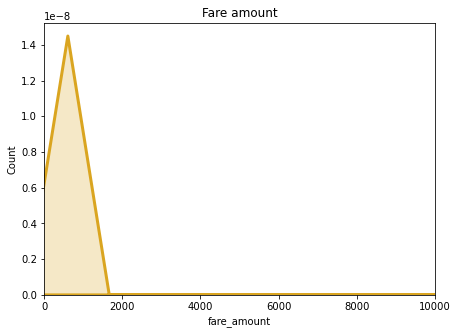

In [61]:
plt.figure(figsize=(7,5))

sns.kdeplot( data = query['fare_amount'], shade = True, linewidth = 3, color = 'goldenrod')
plt.ylabel('Count')
plt.xlim([0,10000])
plt.title('Fare amount')
plt.show()

The time-and-distance fare calculated by the meter. It seems strange to me it has really high values although most of them are exceptions (one value each time).

In [11]:
del_list(fare_l)

In [14]:
del query
gc.collect()
query = pd.DataFrame()

- **Trip distance**

In [99]:
trip_dis = pd.read_sql_query('SELECT trip_distance FROM nyc_taxis', db)

In [128]:
trip_dis.head()

,distance
0,3.9
1,2.3
2,9.2
3,1.1
4,1.0


In [114]:
trip_dis.dtypes

distance    float64
dtype: object

In [100]:
trip_dis_floats = []

for distance in trip_dis['trip_distance']:
    if isinstance(distance, float) == True:
        trip_dis_floats.append(distance)    

In [101]:
trip_dis = pd.DataFrame(trip_dis_floats,columns=['distance'])

Text(0.5, 1.0, 'Trip distance (miles)')

<Figure size 720x432 with 0 Axes>

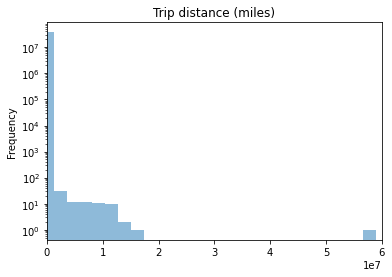

In [134]:
plt.figure(figsize=[10,6])

trip_dis.plot.hist(bins=30, alpha=0.5, legend=False)
plt.yscale('log') 
plt.xlim([0,6*10**7])
plt.title('Trip distance (miles)')

Most of the trips are short or mid-distance, while a few ones are really long, anormal ones.

In [84]:
del trip_dis
gc.collect()
trip_dis = pd.DataFrame()

In [ ]:
del_list( trip_dis_floats)

- **Trip duration and passenger count**

In [144]:
trip_pass = pd.read_sql_query('SELECT VendorID, tpep_pickup_datetime AS pickup, tpep_dropoff_datetime AS dropoff , passenger_count FROM nyc_taxis', db)

In [155]:
trip_pass.head()

,VendorID,pickup,dropoff,passenger_count
0,1,2015-07-01 00:00:00,2015-07-01 00:22:22,1
1,1,2015-07-01 00:00:00,2015-07-01 00:07:42,1
2,1,2015-07-01 00:00:00,2015-07-01 00:39:37,1
3,1,2015-07-01 00:00:00,2015-07-01 00:05:34,1
4,1,2015-07-01 00:00:00,2015-07-01 00:06:46,2


In [158]:
trip_pass.isnull().sum()

VendorID           0
pickup             1
dropoff            1
passenger_count    1
dtype: int64

In [159]:
trip_pass.dropna(inplace=True)

In [160]:
vendorid = []
passenger_count = []
pickup_hour = []
dropoff_hour = []

for _id, count, pickup, dropoff in zip(query['VendorID'], query['passenger_count'], query['pickup'], query['dropoff']):
    if ('_d' not in pickup) == True:
        passenger_count.append(count) 
        vendorid.append(_id)
        pickup_hour.append(pickup[11:])
        dropoff_hour.append(dropoff[11:])

In [162]:
trip_pass = pd.DataFrame(list(zip(vendorid,passenger_count,pickup_hour,dropoff_hour)), columns=['vendorid','passenger_count','pickup_hour','dropoff_hour'])

In [196]:
del_list(vendorid)
del_list(passenger_count)
del_list(pickup_hour)
del_list(dropoff_hour)

In [172]:
trip_pass.head(3)

,vendorid,passenger_count,pickup_hour,dropoff_hour
0,1,1,00:00:00,00:22:22
1,1,1,00:00:00,00:07:42
2,1,1,00:00:00,00:39:37


In [192]:
FMT = '%H:%M:%S'

duration = []

for pickup, dropoff in zip(trip_pass['pickup_hour'], trip_pass['dropoff_hour']):
    
    tdelta = datetime.strptime(dropoff, FMT) - datetime.strptime(pickup, FMT)
    duration.append(tdelta.total_seconds()/60)

In [200]:
trip_pass['duration_min'] = duration

In [202]:
trip_pass.head()

,vendorid,passenger_count,pickup_hour,dropoff_hour,duration_min
0,1,1,00:00:00,00:22:22,22.366667
1,1,1,00:00:00,00:07:42,7.700000
2,1,1,00:00:00,00:39:37,39.616667
3,1,1,00:00:00,00:05:34,5.566667
4,1,2,00:00:00,00:06:46,6.766667


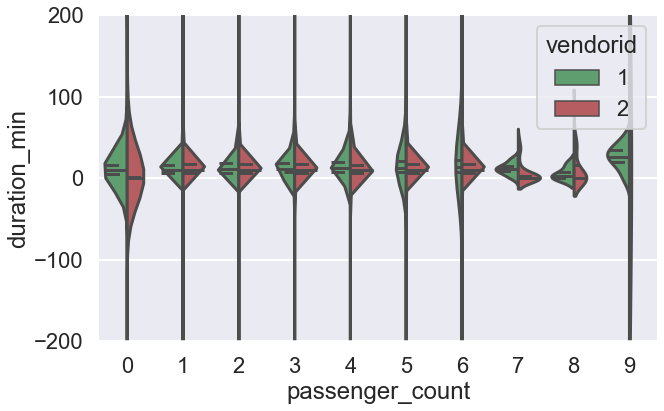

In [210]:
sns.set(color_codes=True)
sns.set_context("poster")

plt.figure(figsize=[10,6])
sns.violinplot(x="passenger_count", y="duration_min", hue="vendorid", data=trip_pass, split=True, inner="quart",palette={1: "g", 2: "r"})
plt.ylim([-200,200])
sns.despine(left=True)

- Vendors are the different TPEP providers:  1= Creative Mobile Technologies, LLC; 2= VeriFone Inc. Both vendros seem to have similar data except when having a high number of passengers (>=4).
- Its is notable there is negative time. I asume that in this cases the dropoff hour is earlier than the pickup hour.
- 0 passengers trip are (maybe) trips in which the taxi is booked to a particular destination for  a pickup.
- Similar duration time with 1,2,3,4 passengers.

In [220]:
del trip_pass
gc.collect()
trip_pass = pd.DataFrame()

In [215]:
del_list(duration)

### ACS and geometries data

In [10]:
nyc_acs.info

<bound method DataFrame.info of                geoid                       acs_demog_var   value
0       360050001001                           total_pop  7080.0
1       360050001001               two_or_more_races_pop    41.0
2       360050001001       vacant_housing_units_for_rent     0.0
3       360050001001                      unemployed_pop     0.0
4       360050001001                           black_pop  3984.0
...              ...                                 ...     ...
199625  361190055004       vacant_housing_units_for_rent     0.0
199626  361190055004         median_year_structure_built     0.0
199627  361190055004                        hispanic_pop    72.0
199628  361190055004  commuters_by_public_transportation   177.0
199629  361190055004                      unemployed_pop    74.0

[199630 rows x 3 columns]>

In [12]:
nyc_geo.info

<bound method DataFrame.info of              geoid                                           geometry
0     360050001001  POLYGON ((-73.89277 40.79284, -73.89261 40.792...
1     360050002001  POLYGON ((-73.86285 40.81267, -73.86191 40.812...
2     360050002002  POLYGON ((-73.86708 40.81444, -73.86332 40.812...
3     360050002003  POLYGON ((-73.85856 40.80665, -73.85848 40.806...
4     360050004001  POLYGON ((-73.85972 40.81527, -73.85956 40.815...
...            ...                                                ...
6334  361190029002  POLYGON ((-73.84512 40.90594, -73.84532 40.905...
6335  361190030002  POLYGON ((-73.85260 40.90698, -73.85256 40.906...
6336  361190035002  POLYGON ((-73.85353 40.90747, -73.85279 40.907...
6337  361190055003  POLYGON ((-73.82324 40.89120, -73.82300 40.891...
6338  361190055004  POLYGON ((-73.81972 40.89021, -73.81956 40.890...

[6339 rows x 2 columns]>

#### Missing data

In [12]:
nyc_acs.isnull().sum()

geoid            0
acs_demog_var    0
value            0
dtype: int64

In [13]:
nyc_geo.isnull().sum()

geoid       0
geometry    0
dtype: int64

Apparently there is no missing data.

#### Combining the two dataframes

Because the two files contain the geoid (block count) feature, I will join then in one dataframe:

In [9]:
nyc_acs = nyc_acs.join(nyc_geo.set_index('geoid'), on='geoid')

In [27]:
nyc_acs.head(3)

,geoid,acs_demog_var,value,geometry
0,360050001001,total_pop,7080.0,"POLYGON ((-73.89277 40.79284, -73.89261 40.792..."
1,360050001001,two_or_more_races_pop,41.0,"POLYGON ((-73.89277 40.79284, -73.89261 40.792..."
2,360050001001,vacant_housing_units_for_rent,0.0,"POLYGON ((-73.89277 40.79284, -73.89261 40.792..."


#### Making a GeoDataframe

I will make a geodataframe to map plotting and also to perform a future spatial join with the NYC taxi data.

In [10]:
gdf_acs = gpd.GeoDataFrame(nyc_acs, geometry=nyc_acs['geometry'])
gdf_acs.crs = 4326
gdf_acs = gdf_acs.to_crs(epsg=3857)
gdf_acs.reset_index(drop=True, inplace=True)

In [11]:
del nyc_acs
gc.collect()
nyc_acs = pd.DataFrame()

#### Data exploration

These are the ACS demographical variables for each block count:

In [12]:
nyc_acs[nyc_acs['geoid']==360050001001]['acs_demog_var'].unique()

array(['total_pop', 'two_or_more_races_pop',
       'vacant_housing_units_for_rent', 'unemployed_pop', 'black_pop',
       'female_pop', 'commuters_by_public_transportation', 'hispanic_pop',
       'nonfamily_households', 'white_pop', 'commuters_16_over',
       'median_age', 'vacant_housing_units', 'pop_16_over',
       'families_with_young_children', 'occupied_housing_units',
       'households', 'housing_units', 'asian_pop', 'family_households',
       'housing_units_renter_occupied', 'employed_pop', 'male_pop',
       'married_households', 'other_race_pop', 'amerindian_pop',
       'income_per_capita'], dtype=object)

Lets explore some movility related variables:

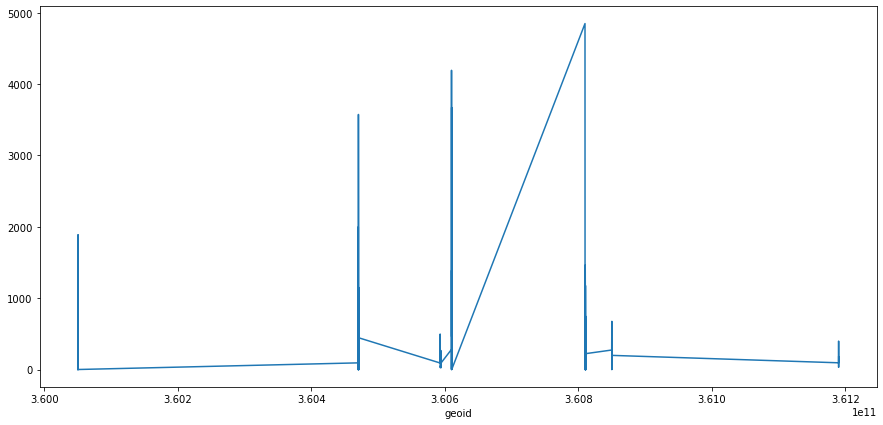

In [21]:
fig, ax = plt.subplots(figsize=(15,7))

filter1 = nyc_acs[nyc_acs['acs_demog_var']=='commuters_by_public_transportation']
filter1.groupby(['geoid']).sum()['value'].plot(ax=ax)

There are more commuters in the 3605, 3606 and 3608 block groups.

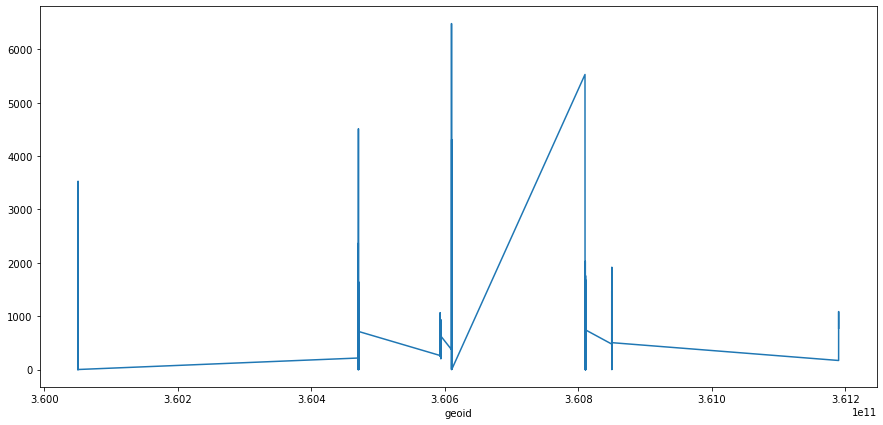

In [22]:
fig, ax = plt.subplots(figsize=(15,7))

filter1 = nyc_acs[nyc_acs['acs_demog_var']=='commuters_16_over']
filter1.groupby(['geoid']).sum()['value'].plot(ax=ax)

The results indicate that the same block groups that have more commuters by public transportation also have more commuters over 16 in general, although the numerical difference is up to the total commuters (public + private) vs public transportation commuters.

Now I want to visualize the spatial data:

Text(0.5, 1.0, 'NYC')

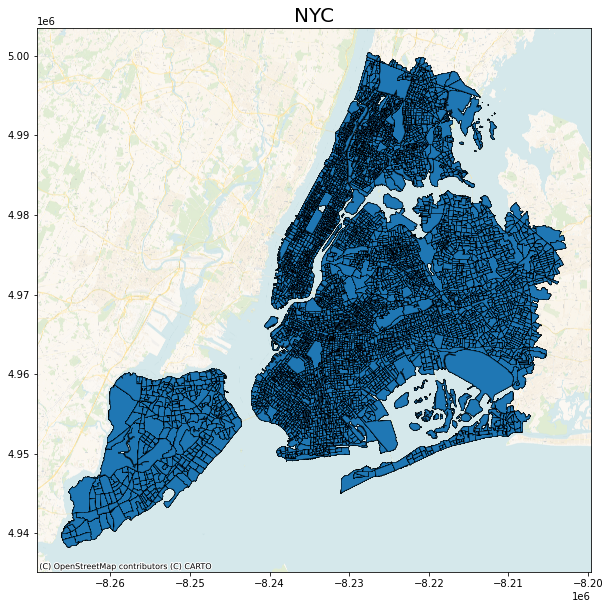

In [21]:
ax = gdf_acs.plot(figsize=(10, 10),color=None, alpha=0.5, edgecolor='k', linewidth = 0.5)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, zoom = 15)

plt.title('NYC', fontsize=20)

Text(0.5, 1.0, 'NYC Boroughs')

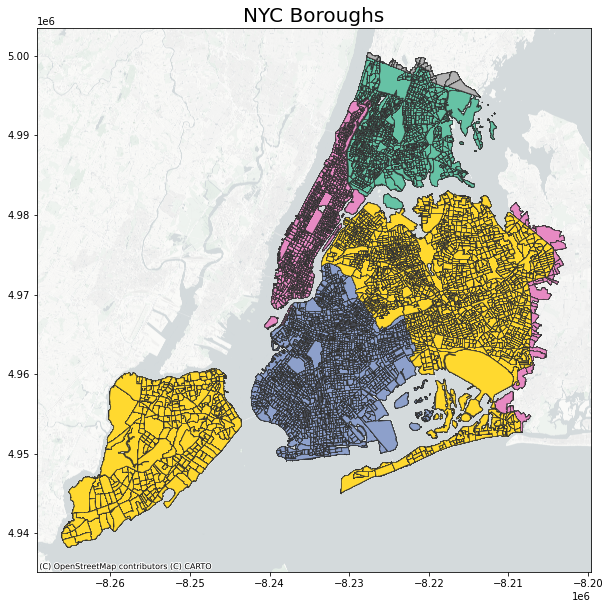

In [27]:
ax = gdf_acs.plot(figsize=(10, 10), column = 'geoid', cmap = 'Set2', linewidth=.6, edgecolor='0.2', legend = False)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom = 15)

plt.title('NYC Boroughs', fontsize=20)

This groups correspond to the NYC boroughs aproximately:
- Bronx in green.
- Brooklyn in blue
- Mahattan in pink at the center
- Queens in yellow at the center
- Staten island in yellow at shoutwest.

#### Merge NYC taxi data and ACS data by block group: spatial join

I will create a geometry feature for the NYC taxi data which allows a spatial join to merge both datasets:

In [12]:
nyc_taxis_pcoords = pd.read_sql("SELECT pickup_latitude AS lat, pickup_longitude AS lon FROM nyc_taxis", db)

In [17]:
nyc_taxis_pcoords.head(3)

,lat,lon
0,40.768486,-73.984657
1,40.762287,-73.978889
2,40.742760,-73.992790


In [21]:
nyc_taxis_pcoords.dtypes

lat    object
lon    object
dtype: object

There is probably floats and integers/strings mixed (error after trying changing data type), so I will create a new clean dataframe:

In [13]:
lat = []
lon = []

for i,j in zip(nyc_taxis_pcoords['lat'], nyc_taxis_pcoords['lon']):
    if isinstance(i, float) == True and isinstance(j, float) == True:
        lat.append(i)   
        lon.append(j)   

In [14]:
nyc_taxis_pcoords = pd.DataFrame(list(zip(lat,lon)),columns=['lat', 'lon'])

In [15]:
del_list(lat)
del_list(lon)

In [16]:
gdf_nyc_taxis = gpd.GeoDataFrame(nyc_taxis_pcoords, geometry=gpd.points_from_xy(nyc_taxis_pcoords.lon, nyc_taxis_pcoords.lat))
gdf_nyc_taxis.crs = 4326
gdf_nyc_taxis = gdf_nyc_taxis.to_crs(epsg=3857)

In [17]:
gdf_nyc_taxis.drop(['lon','lat'], axis=1, inplace=True)
gdf_nyc_taxis.reset_index(drop=True, inplace=True)

In [18]:
del nyc_taxis_pcoords
gc.collect()
nyc_taxis_pcoords = pd.DataFrame()

In [35]:
gdf_nyc_taxis.head()

,geometry
0,POINT (-8235934.376 4978253.146)
1,POINT (-8235292.305 4977342.047)
2,POINT (-8236839.730 4974472.502)
3,POINT (-8227894.050 4978447.711)
4,POINT (-8233096.014 4978979.842)


I tried to change some data types to save memory:

In [25]:
gdf_acs.info(memory_usage='deep')

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 199630 entries, 0 to 199629
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   geoid          199630 non-null  int64   
 1   acs_demog_var  199630 non-null  object  
 2   value          199630 non-null  float64 
 3   geometry       199630 non-null  geometry
dtypes: float64(1), geometry(1), int64(1), object(1)
memory usage: 18.9 MB


In [19]:
gdf_acs['acs_demog_var'] = gdf_acs['acs_demog_var'].astype('category')
gdf_acs['value'] = gdf_acs['value'].astype('float32')

In [35]:
gdf_acs.info(memory_usage='deep')

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 199630 entries, 0 to 199629
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   geoid          199630 non-null  int64   
 1   acs_demog_var  199630 non-null  category
 2   value          199630 non-null  float32 
 3   geometry       199630 non-null  geometry
dtypes: category(1), float32(1), geometry(1), int64(1)
memory usage: 4.0 MB


At this point I permorfed a spatial join to determine which points (pickups) are inside each polygon (block group) but this result in a very long (hours..) computing time which leaded to memory errors and empty results.

To continue with the project I will extract 5000 entries of each month as a sample to at least continue the data analysis process and modelling.

In [20]:
gdf_nyc_taxis1 = gdf_nyc_taxis.iloc[0:5000]
gdf_nyc_taxis2 = gdf_nyc_taxis.iloc[500000:505000]
gdf_nyc_taxis3 = gdf_nyc_taxis.iloc[13248987:13253987]

gdf_nyc_taxis_reduced = pd.concat([gdf_nyc_taxis1, gdf_nyc_taxis2, gdf_nyc_taxis3], axis = 0)

In [21]:
del gdf_nyc_taxis1
del gdf_nyc_taxis2
del gdf_nyc_taxis3
gc.collect()
gdf_nyc_taxis1 = pd.DataFrame()
gdf_nyc_taxis2 = pd.DataFrame()
gdf_nyc_taxis3 = pd.DataFrame()

In [22]:
sjoin_data = gpd.sjoin(gdf_nyc_taxis_reduced,gdf_acs, op='within')

In [105]:
sjoin_data.head()

,geometry,index_right,geoid,acs_demog_var,value
0,POINT (-8235934.376 4978253.146),118339,360610145004,nonfamily_households,327.0
197,POINT (-8235683.832 4978152.220),118339,360610145004,nonfamily_households,327.0
222,POINT (-8235681.284 4978111.289),118339,360610145004,nonfamily_households,327.0
426,POINT (-8235749.228 4978132.035),118339,360610145004,nonfamily_households,327.0
663,POINT (-8235928.431 4978256.510),118339,360610145004,nonfamily_households,327.0


I will group the geoid feature/block groups to extract the average number of pickups by block group.

In [23]:
block_groups_grouped = sjoin_data.groupby(["geoid"]).size().reset_index()

In [57]:
block_groups_grouped.head()

,geoid,0
0,360050019001,32
1,360050051002,32
2,360050197004,30
3,360050235011,31
4,360050256001,32


Then I divide each sum by the total of points to obtain the average value per block group: 

In [24]:
block_groups_grouped.columns = ['geoid','avg_pickups']
block_groups_grouped['avg_pickups'] = block_groups_grouped['avg_pickups']/block_groups_grouped['avg_pickups'].sum()

In [108]:
block_groups_grouped.head()

,geoid,avg_pickups
0,360050019001,0.000069
1,360050051002,0.000069
2,360050197004,0.000065
3,360050235011,0.000067
4,360050256001,0.000069


In [26]:
block_groups_grouped.to_csv('avg_pickups_blockgroup.csv', index=False)

## Modelling

I will train a regression model to predict a continuos value (average number of pickups by block group) using the ACS dataset variables.

First I will create a new feature which retains the average number of pickups by block group obtained eairlier:

In [27]:
data = sjoin_data.copy()

average_pickups = []

for geoid in data['geoid']:
    average_pickups.append(block_groups_grouped[block_groups_grouped['geoid']==geoid]['avg_pickups'].values[0])

In [28]:
data['avg_pickups'] = average_pickups

In [29]:
data.drop(['geometry', 'index_right'], axis=1, inplace=True)

In [31]:
data.head()

,geoid,acs_demog_var,value,avg_pickups
0,360610145004,nonfamily_households,327.0,0.003875
197,360610145004,nonfamily_households,327.0,0.003875
222,360610145004,nonfamily_households,327.0,0.003875
426,360610145004,nonfamily_households,327.0,0.003875
663,360610145004,nonfamily_households,327.0,0.003875


In [80]:
del_list(average_pickups)

In [83]:
del sjoin_data
del block_groups_grouped
gc.collect()
sjoin_data = pd.DataFrame()
block_groups_grouped = pd.DataFrame()

### Train-test split

Is is needed a train and a test dataset to validate the model after training.

In [36]:
train, test = train_test_split(data, test_size=0.2, random_state=0)

### Data distribution

I want to see how the features are distributed so may they need some transformations.

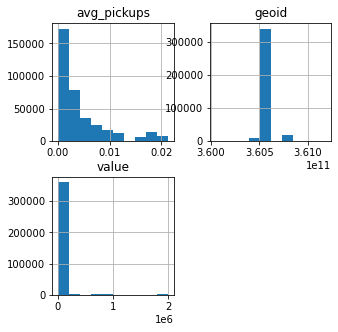

In [142]:
data_distribution = train.hist(figsize=(5,5))

C:\Users\Sergio\Anaconda3\envs\gis\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


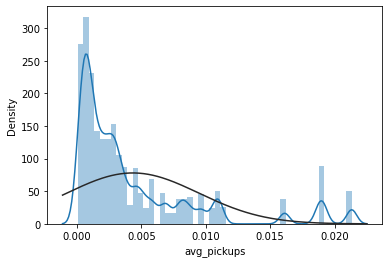

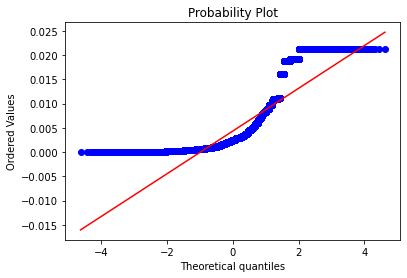

In [143]:
sns.distplot(train['avg_pickups'], fit=stats.norm)
fig = plt.figure()
res = stats.probplot(train['avg_pickups'], plot=plt)

The target label, average pickups, is skewed and have high kurtosis (the tail region may act as an outlier and the distribution is peacked)

### Categorical encoding

It is needed to encode the categorical values to feed them to the model.

In [37]:
le = LabelEncoder()

train['acs_demog_var'] = le.fit_transform(train['acs_demog_var'].astype('string'))
test['acs_demog_var'] = le.transform(test['acs_demog_var'].astype('string'))

C:\Users\Sergio\Anaconda3\envs\gis\lib\site-packages\geopandas\geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [38]:
train.head(3)

,geoid,acs_demog_var,value,avg_pickups
2558,360610128001,10,430.0,0.001799
13249641,360610069001,3,30.0,0.002640
501609,360610099001,12,3846.0,0.011132


### Transform target variable

I will transform (logarithm) the target label to have a normal like distribution which will enpower the regression model.

In [39]:
train['avg_pickups'] = np.log(train['avg_pickups'])

C:\Users\Sergio\Anaconda3\envs\gis\lib\site-packages\geopandas\geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


C:\Users\Sergio\Anaconda3\envs\gis\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


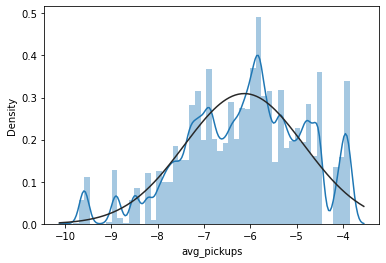

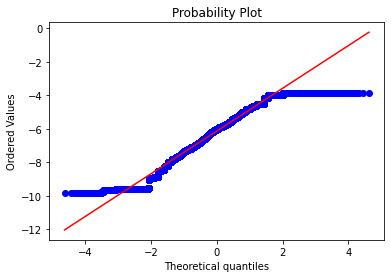

In [181]:
sns.distplot(train['avg_pickups'], fit=stats.norm);
fig = plt.figure()
res = stats.probplot(train['avg_pickups'], plot=plt)

### Scaling data

To improve the classification I will apply a transformation of the data to normalize it.

In [41]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train.drop('avg_pickups',axis=1))
scaled_test = scaler.transform(test.drop('avg_pickups',axis=1))

### Model

In [42]:
X_train = scaled_train
y_train = train['avg_pickups'].values

X_test = scaled_test
y_test = test['avg_pickups'].values

Due to computing time I will just select one estimator: **Gradient boosting** because performs well generally. A resume of this algorithm is:

- Optimizes the mean squared error (MSE)/L2 loss/cost
- GBM is a composite model that combines the efforts of multiple weak models to create a strong model, and each additional weak model reduces the mean squared error (MSE) of the overall model. 



In [60]:
gbr = GradientBoostingRegressor(n_estimators=500, max_depth=5, learning_rate=0.1, random_state=0)
gbr.fit(X_train,y_train)
y_pred = np.exp(gbr.predict(X_test)) # applying exponential transformation to revert the previous logarithm one.

In [61]:
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

RMSE: 0.0008880889672793613


In [62]:
y_pred

array([0.00194543, 0.00042063, 0.00340771, ..., 0.00268878, 0.00181762,
       0.0005333 ])

In [63]:
y_test

array([0.00301644, 0.00025948, 0.00290617, ..., 0.00311375, 0.00117631,
       0.00073735])

The **RMSE is 0.000888** which is a little high. Due to this model has not been trained with all the data it is clear it can be improved, feeding it with more data and also testing other algorithms and with hyperparameter tuning.

## Conclusions

- Work with large files is complicated and time-costly if you have an average computer (and some times impossible if you ran out of RAM memory). It is clear cloud computing is needed to agilize and empower all big data process.All process on the cloud like accessing data, transformations and model training tend to be more efficient.


- Load data in chunks is essential sometimes to perform efficient manipullation.


- The ETL process could be scaled for larger data with pipelines, pretrained objects (scalers, encoders...), etc., automatizing the extraction, transformation, data cleaning, etc. Also the modelling could be done with distributed tools to accelerate it (Spark, Amazon Sagemaker...).


- Future improvements for the model are: more accurate feature transformations, test more estimators to find which one suits best, test more hyperparameters, try K-Fold and Leave-one-out cross validation...


- In modelling it is important to choose the correct algorithm but also to get the best of it with hyperparameter tunning and adecuating the variables to enpower it by doing a correct data analysis and feature engineering.